# Intelligent search for the most relevant questions on [stackoverflow.com](https://stackoverflow.com) for machine learning query

In [1]:
import os
import re
import time
import json
import random
import numpy as np
import pandas as pd
from datetime import date
from copy import deepcopy
from collections import Counter, defaultdict

#from stackapi import StackAPI

import warnings
warnings.filterwarnings('ignore')

# Acquiring data

Data will be fetched using python wrapper [StackAPI](https://stackapi.readthedocs.io/en/latest/) for [StackExchange API](https://api.stackexchange.com).

In [169]:
def receive_all(site, endpoint, tag, filt):
    """Receive data from api.stackexchange.com.
    """
    questions = []
    npage = 1
    while True:
        try:
            data = site.fetch(endpoint, tagged=tag, page=npage, filter=filt)
        except Exception as e:
            print(e)
            return questions
        print(f'{npage} page - ok')
        questions.extend(data['items'])
        if not data['has_more']:
            break
        npage += site.max_pages
        # Wait to prevent blocking by api.stackexchange.com.
        time.sleep(65)
    return questions

def append_csv(path, data, sep=','):
    """Append data to csv file from path.
    """
    with open(path, 'r') as f:
        cols = f.readline()
    cols = cols.replace('\n', '').split(sep)
    pd.DataFrame(data).to_csv(path, index=False, mode='a', columns=cols, header=False)

Try to retrieve the questions tagged by machine-learning

In [12]:
site = StackAPI('stackoverflow')
site.page_size = 100
site.max_pages = 50
# Adjusted filter to receive only the certain fields(features).
filter_ = "!)riR77pKTViDr-BtOA65"

In [ ]:
ml_questions = receive_all(site, 'questions', 'machine-learning', filter_)

Save the retrieved data

In [ ]:
pd.DataFrame(ml_questions).to_csv('data/questions.csv', index=False)

Acquire more data

In [ ]:
related_tags = ['classification', 'scikit-learn', 'svm', 'random-forest', 'linear-regression', 
                'logistic-regression', 'regression', 'cluster-analysis','k-means']

In [ ]:
for tag in related_tags:
    qs = receive_all(site, 'questions', tag, filter_)
    append_csv('data/questions.csv', qs)

_Note: this fragment was made to receive more data for existing dataset because of StackExchange limitations on data obtaining._

## Read the data

In [2]:
df = pd.read_csv('data/questions.csv', parse_dates=['last_activity_date', 'creation_date'], 
                 date_parser=lambda sec: date.fromtimestamp(float(sec)))

In [3]:
print(f'{min(df.creation_date)} - {max(df.creation_date)}')

2008-09-01 00:00:00 - 2020-01-14 00:00:00


Raw data

In [3]:
df.head()

accepted_answer_id  answer_count  \
0                 NaN             2   
1                 NaN             1   
2                 NaN             1   
3                 NaN             0   
4                 NaN             2   

                                                body  comment_count  \
0  <p>As I read in R package GMDH a function for ...              0   
1  <p>I have 7 classes of inputs that are related...              0   
2  <p>I have a data set of tweets, where each twe...              7   
3  <p>I have a database with products images, des...              0   
4  <p>In my CNN architecture for binary classific...              0   

  creation_date  is_answered last_activity_date  \
0    2016-03-21        False         2020-01-12   
1    2020-01-12        False         2020-01-12   
2    2020-01-07        False         2020-01-12   
3    2020-01-06        False         2020-01-12   
4    2020-01-12        False         2020-01-12   

                                                link  question_id  score  \
0  https://stackoverflow.com/questions/36124798/c...     36124798      1   
1  https://stackoverflow.com/questions/59704583/h...     59704583      0   
2  https://stackoverflow.com/questions/59630544/c...     59630544      0   
3  https://stackoverflow.com/questions/59618534/h...     59618534      0   
4  https://stackoverflow.com/questions/59701081/s...     59701081      0   

                                                tags  \
0                                 ['classification']   
1  ['matlab', 'machine-learning', 'classification...   
2  ['python', 'regression', 'classification', 'te...   
3  ['python', 'mysql', 'classification', 'tensorf...   
4  ['math', 'deep-learning', 'classification', 'c...   

                                               title  view_count  
0  can we use GMDH for two or three class classii...         172  
1  How to Improve Classification Accuracy with Su...           9  
2  Can sentiment classification problem be resolv...          51  
3         How to train tensorflow with text samples?          19  
4  Stuck in the calculations of matrix sizes for ...          24

In [392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62280 entries, 0 to 62279
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   accepted_answer_id  26067 non-null  float64       
 1   answer_count        62280 non-null  int64         
 2   body                62280 non-null  object        
 3   comment_count       62280 non-null  int64         
 4   creation_date       62280 non-null  datetime64[ns]
 5   is_answered         62280 non-null  bool          
 6   last_activity_date  62280 non-null  datetime64[ns]
 7   link                62280 non-null  object        
 8   question_id         62280 non-null  int64         
 9   score               62280 non-null  int64         
 10  tags                62280 non-null  object        
 11  title               62280 non-null  object        
 12  view_count          62280 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(1), int

Only accepted_answer_id have NaNs

In [350]:
df.describe()

accepted_answer_id  answer_count  comment_count   question_id  \
count        2.606700e+04  62280.000000   62280.000000  6.228000e+04   
mean         4.048002e+07      1.102714       1.625080  4.278908e+07   
std          1.491918e+07      1.030702       2.342053  1.426483e+07   
min          3.730100e+04      0.000000       0.000000  3.729600e+04   
25%          3.140038e+07      1.000000       0.000000  3.478386e+07   
50%          4.473990e+07      1.000000       1.000000  4.674207e+07   
75%          5.226237e+07      1.000000       2.000000  5.441796e+07   
max          5.973257e+07     29.000000      37.000000  5.973897e+07   

              score     view_count  
count  62280.000000   62280.000000  
mean       1.674342    1469.319059  
std        8.570109    7025.534051  
min      -74.000000       3.000000  
25%        0.000000      63.000000  
50%        0.000000     247.000000  
75%        2.000000     844.000000  
max      766.000000  480375.000000

# Data preprocessing

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

from nltk import pos_tag, download
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# download('stopwords')
# download('punkt')
# download('averaged_perceptron_tagger')
# download('wordnet')

STOPWORDS = set(stopwords.words('english'))

## Text preparing

The main features I will have to deal with are 'title' and 'body'.

Let's take a look at some of them:

In [5]:
df.body[27]

'<p>I want to use classification tecs in machine learning. But the dataset i have has different dimension. Like <code>sample_1 = [s10, s11, s12, s13]</code>, <code>sample_2 = [s20, s21, s22, s23, s24, s25, s26]</code>. How to use dataset like this?\nThe actual dataset is from the nyquist plot in electrochemical impedance spectra. The nyquist plot looks like this image <a href="https://i.stack.imgur.com/dRhH2.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/dRhH2.png" alt="simultation result model"></a></p>\n\n<p>The data are the coordinates of the points in the plot. The plot can be draw by 20 points or any number of points. So this caused the <code>dimension imparity trouble</code>. Anyone familar with this?</p>\n'

In [29]:
df.title[23]

'Can I build a ML model with independent variables containing (time series+ categorical +numeric) and a classifier dependent variable (0,1)'

#### Problems:

1. Tags => retrieve context
2. `<code> .. </code>, <img>, <a href=..>` => del whole context
3. AUC, 3D CNN, DNN, ResNet => nothing
4. 3-D, Non-linear => separate by whitespace
5. can't => nothing (stopwords cleans it)
6. 'β'(UnkNowN symbols) => del
7. punctuations => del
8. HTML Entities: `&#39;`, `&quot;` => del


In [7]:
class TextCleaner(BaseEstimator, TransformerMixin):
    """Clean text by removing all symbols, except the letters and single witespaces
    
    Parameters
    ----------
    swt : int, default=2
        stop words threshold, words with length < swt will be removed.
        
    retr_type : str, default='array'
        Return type of transformed data.
        
        'array' -- numpy.array;
        'list' -- built-in list.
    """
    
    def __init__(self, swt=2, retr_type='array'):
        self.swt = swt
        self.retr_type = retr_type
        
    def __repr__(self):
        return f'TextCleaner(swt={self.swt}, retr_type={self.retr_type})'
    
    def fit(self, X, y=None):
        """Fit the cleaner on X

        X : 1D or 2D array-like of str
        y
            Ignored
        """
        if X is None: 
            raise ValueError("Can't transform None type")
        if self.retr_type not in ['list', 'array']:
            raise ValueErrot('Unknown retr_type, retr_type must be list or array')
            
        self.reText = re.compile(r'(?<=&)\w+(?=;)|(?<=\d)[A-z]+(?=\d)|[^a-z\s]')
        return self
    
    def transform(self, X):
        """Purify X.
        """
        xcl = [self._clean_text(doc) for doc in X]
        if self.retr_type == 'array':
            return np.array(xcl)
        return xcl

    def _clean_str(self, s):
        s = self.reText.sub(' ', s.lower())
        s = re.sub(r'\s+', ' ', s).strip()
        words = s.split()
        return ' '.join(w for w in words if w not in STOPWORDS and len(w) >= self.swt)
        
    def _clean_text(self, document):
        if isinstance(document, str) or isinstance(document, np.str_):
            return self._clean_str(document)
        clean_doc = []
        for s in document:
            clean_doc.append(self._clean_str(s))
        return clean_doc


class HtmlCleaner(TextCleaner):
    """Clean HTML text, it is derived from TextCleaner."""
    
    def __init__(self, swt=2, retr_type='array'):
        super().__init__(swt, retr_type)
    
    def __repr__(self):
        return f'HtmlCleaner(swt={self.swt}, retr_type={self.retr_type})'
    
    def fit(self, X):
        super().fit(X)
        self.reHTML = re.compile(
            r'\n|<code>(.|\n)*?</ *code>' 
            + '|<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});' 
            + '|https?:\S+')  
        return self
    
    def transform(self, X):
        xcl = [self._clean_html(doc) for doc in X]
        if self.retr_type == 'array':
            return np.array(xcl)
        return xcl
    
    def _clean_html(self, document):
        if isinstance(document, str) or isinstance(document, np.str_):
            s = self.reHTML.sub(' ', document)
            return self._clean_str(s)
        clean_doc = []
        for s in document:
            s = self.reHTML.sub(' ', s)
            clean_doc.append(self._clean_str(s))
        return clean_doc
    

class ColumnSelector(BaseEstimator, TransformerMixin):
    """Return field of X."""
    
    def __init__(self, field=None):
        self.field = field
        
    def fit(self, X, y=None):
        """Check field presence.
        """
        if self.field not in X:
            raise KeyError('No such field')
        return self
    
    def transform(self, X):
        return X[self.field]

In [141]:
tc = TextCleaner()
tc.fit_transform(df.title[:2])

array(['use gmdh two three class classiication',
       'improve classification accuracy support vector machine'],
      dtype='<U54')

In [34]:
htmlc = HtmlCleaner()
htmlc.fit_transform(df.body[:2])

array(['read package gmdh function short term forecasting univariate time series using gmdh type neural network algorithms use iris dataset',
       'classes inputs related brain signals activity eeg number classes large performance classification algorithms may affected see following code extracted features first phase trained model data got accuracy testing phase remaining get accuracy suggestion improve accuracy model'],
      dtype='<U274')

It seems good

### Lemmatization and Stemming

In [161]:
class TextNormalizer(BaseEstimator, TransformerMixin):
    """Tokenize and apply lemmatization or stemming to text
    
    Parameters
    ----------
    method : str, default='lemma'
        The normalizing technique.
        
        'lemma' -- lemmatization
        'stem' -- stemming
        
    retr_type : str, default='array'
        Return type of transformed data.
        
        'array' -- numpy.array
        'list' -- built-in list
    """
    
    def __init__(self, method='lemma', retr_type='array'):
        self.method = method
        self.retr_type = retr_type
    
    def __repr__(self):
        return f'TextNormalizer(method={self.method}, retr_type={self.retr_type})'
    
    def fit(self, X, y=None):
        """Initialize normalizer.
        """
        if self.method == 'lemma':
            self.lematizer = WordNetLemmatizer()
            self.normalizer = self._lem
        elif self.method == 'stem':
            self.porter_stemmer = PorterStemmer()
            self.normalizer = self._stem
        else:
            raise ValueError('Unknown method')
        if self.retr_type not in ['array', 'list']:
            raise TypeError('ret_type must be list or array')
        return self
        
    def transform(self, X):
        """Normalize X.
        """
        X_new = [self.normalizer(row) for row in X]
        if self.retr_type == 'array':
            return np.array(X_new)
        return X_new

    def _get_wordnet_pos(self, word):
        """Map POS tag to first character lemmatize() accepts.
        """
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {'J': wordnet.ADJ,
                    'N': wordnet.NOUN,
                    'V': wordnet.VERB,
                    'R': wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    def _lem(self, row):
        if isinstance(row, str) or isinstance(row, np.str_):
            words = word_tokenize(row)
            for i in range(len(words)):
                words[i] = self.lematizer.lemmatize(words[i], pos=self._get_wordnet_pos(words[i]))
            return words
        sents = []
        for sent in row:
            words = word_tokenize(sent)
            for i in range(len(words)):
                words[i] = self.lematizer.lemmatize(words[i], pos=self._get_wordnet_pos(words[i]))
            sents.append(words)
        return sents if self.retr_type == 'list' else np.array(sents)
            
    def _stem(self, row):
        if isinstance(row, str) or isinstance(row, np.str_):
            words = word_tokenize(row)
            for j in range(len(words)):
                words[j] = self.porter_stemmer.stem(words[j])
            return words
        sents = []
        for sent in row:
            words = word_tokenize(sent)
            for j in range(len(words)):
                words[j] = self.porter_stemmer.stem(words[j])
            sents.append(words)
        return sents

Check it for the first 2 titles

In [170]:
stem = TextNormalizer(method='stem')
stem.fit_transform(df.title[0:2])

array([list(['can', 'we', 'use', 'gmdh', 'for', 'two', 'or', 'three', 'class', 'classiic']),
       list(['how', 'to', 'improv', 'classif', 'accuraci', 'with', 'support', 'vector', 'machin'])],
      dtype=object)

### Make pipeline to clean and normalize titles and bodies and save them for convenience of further use:

In [508]:
txt_preparer = Pipeline([
    ('col_selector', ColumnSelector()),
    ('cleaner', TextCleaner(retr_type='list')),
    ('normalize', TextNormalizer(retr_type='list'))
])

In [509]:
txt_preparer.get_params()

{'memory': None,
 'steps': [('col_selector', ColumnSelector()),
  ('cleaner', TextCleaner(retr_type='list')),
  ('normalize', TextNormalizer(retr_type='list'))],
 'verbose': False,
 'col_selector': ColumnSelector(),
 'cleaner': TextCleaner(retr_type='list'),
 'normalize': TextNormalizer(retr_type='list'),
 'col_selector__field': None,
 'cleaner__retr_type': 'list',
 'cleaner__swt': 2,
 'normalize__method': 'lemma',
 'normalize__retr_type': 'list'}

In [40]:
fields, methods = ['title', 'body'], ['lemma', 'stem']

Apply

In [533]:
for field in fields:
    if field == 'body':
        txt_preparer.set_params(cleaner=HtmlCleaner(retr_type='list'))
    for method in methods:
        txt_preparer.set_params(col_selector__field=field, normalize__method=method)
        X = txt_preparer.fit_transform(df)
        with open(f'data/documents/{field}_{method}.json', 'w') as write_file:
            #json.dump(X, write_file)

# Data visualization

In [124]:
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
# Set notebook mode to work in offline.
pyo.init_notebook_mode()

import seaborn as sns
sns.set(style='darkgrid')

from wordcloud import WordCloud

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [205]:
def make_tag_vocab(df):
    """Count tag frequency from df.tags.
    """
    tag_counter = Counter()
    rebr = re.compile(r"'([^']+)'")
    for tags in df.tags:
        tag_counter += Counter(rebr.findall(tags))
    return tag_counter

def plot_top_tags(tvocab, k):
    """Plot k the most frequent tags.
    """
    top = tvocab.most_common(k)
    fig = plt.figure(figsize=(8, 7))
    sns.barplot(y=[el[0] for el in top], x=[el[1] for el in top], orient='h', palette='pastel')
    plt.xticks(rotation=45)
    plt.title(f'Top {k} tags')
    plt.show()

In [319]:
df.tags

0                                       ['classification']
1        ['matlab', 'machine-learning', 'classification...
2        ['python', 'regression', 'classification', 'te...
3        ['python', 'mysql', 'classification', 'tensorf...
4        ['math', 'deep-learning', 'classification', 'c...
                               ...                        
62275                     ['java', 'algorithm', 'k-means']
62276                                     ['r', 'k-means']
62277    ['algorithm', 'image', 'image-processing', 'op...
62278    ['algorithm', 'image-processing', 'computer-vi...
62279                 ['c#', 'sql', 'database', 'k-means']
Name: tags, Length: 62280, dtype: object

Figure out 10 the most frequent tags in the dataset

In [206]:
tvocab = make_tag_vocab(df)

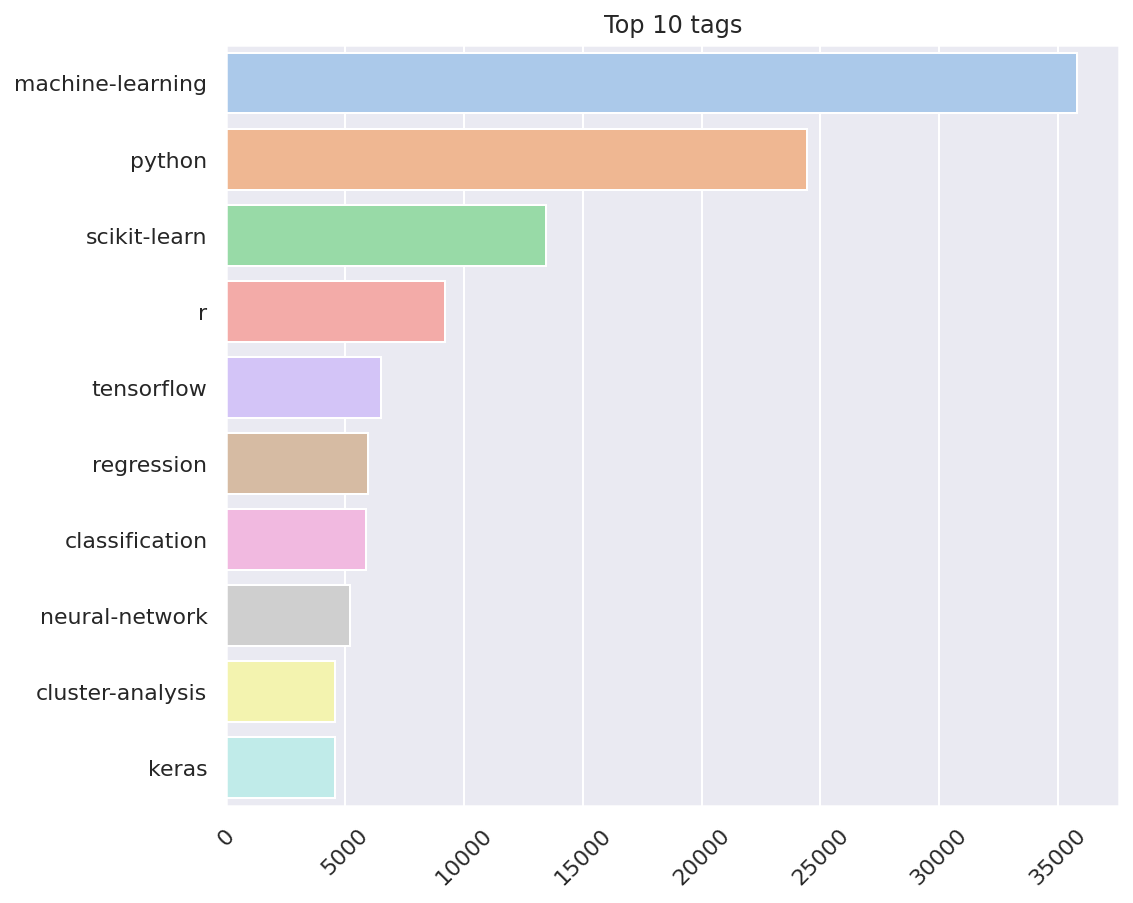

In [211]:
plot_top_tags(tvocab, 10)

### Tags trend

Let's calculate the annual popularity(density) of each tag among all the ml-related tags.

$$Density[year][tag] = \frac{N_{ty}}{N_y}$$
$N_{ty}$ - Number of occurences of the tag per year,

$N_y$ - Total number of tags per year.

In [507]:
def get_ytd(df):
    """Calculate the yearly tag densities.
    """
    tag_extr = re.compile(r"'([^']+)'")
    trend_map = defaultdict(lambda: defaultdict(int))
    for row in df.itertuples():
        tags = tag_extr.findall(row.tags)
        for tag in tags:
            trend_map[row.creation_date.year][tag] += 1
    # Remove 2020 year
    if 2020 in trend_map:
        del trend_map[2020]
    for year, tags in trend_map.items():
        amount_tags = sum(tags.values())
        for tag in tags:
            trend_map[year][tag] /= amount_tags
    return trend_map

Compute tag density map

In [510]:
yearly_trends = get_ytd(df)

And plot them

In [534]:
def plot_tag_density(yearly_trends, tag):
    """Plot density of the tag per year.
    """
    tag = tag.lower()
    years, tag_number = [], []
    for year, trend in sorted(yearly_trends.items()):
        if trend[tag] > 0:
            years.append(year)
            tag_number.append(trend[tag])
    title = f'{tag.capitalize()} trend (ml)'
    ytitle = f'{tag} tags / all ml tags'
    plot_bar(years, tag_number, title=title, ytitle=ytitle)


def plot_bar(years, y, text=None, title=None, ytitle=None, c=None):
    """Show plot of the tag density for each year.
    """         
    fig = go.Figure()
    fig.add_trace(go.Bar(x=years, y=y, text=text, 
                         textposition='outside', marker_color=c))
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    fig.add_trace(go.Scatter(x=years, y=y))
    fig.update_layout(
        title={
            'text': title,
            'x':0.5, 'y':0.9,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        showlegend=False,
        yaxis_title=ytitle, 
        xaxis_title='year', 
        autosize=True, 
        font={'family': 'Courier New, monospace', 'size': 16, 'color': '#404040'},
        xaxis={'tickmode': 'linear', 'dtick': 1}
    )
    fig.show()

Something is getting popular

In [456]:
plot_tag_density(yearly_trends, 'python')

Try guess why deep-learning have the highest rate in 2017.

In [457]:
plot_tag_density(yearly_trends, 'deep-learning')

AlphaGo?

Something becomes less popular

In [458]:
plot_tag_density(yearly_trends, 'r')

Or unpopular

In [459]:
plot_tag_density(yearly_trends, 'matlab')

### The largest year growth

In [537]:
def plot_tag_growth(yearly_trends):
    """Plot tags with the largest increase compared to last year.
    """
    yps, years, tag_number = [], [], []
    #low = min(yearly_trends, key=lambda x: yearly_trends[x])
    for year, trend in sorted(yearly_trends.items()):
        max_year_growth = 0
        sup = None
        for t in trend:
            prev = yearly_trends[year-1][t]
            if prev <= 0: prev = 1
            yg = yearly_trends[year][t] / prev
            if yg > max_year_growth:
                max_year_growth = yg
                sup = t
        if sup is None: continue
        years.append(year)
        yps.append(sup)
        tag_number.append(max_year_growth)
    title = 'The largest tag density growth per year'
    plot_bar(years, tag_number, yps, title=title, ytitle='growth', c='rgb(66, 148, 155)')

In [539]:
plot_tag_growth(yearly_trends)

### What about context of questions?

Consider lemmatized data and build wordclouds for questions

In [125]:
 def draw_wordcloud(documents):
    """Draw wordcloud from documents.
    """
    words = []
    for t in documents:
        words.extend(t)
    vocab = Counter(words)
    wordcloud = WordCloud(
        width=1600, height=800,
        max_font_size=200,
        background_color='white',
        collocations=False
    ).generate_from_frequencies(vocab) 

    plt.figure(figsize=(12,11))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [126]:
with open('data/documents/title_lemma.json', 'r') as t, \
      open('data/documents/body_lemma.json', 'r') as b:
    titles_lem = json.load(t)
    bodies_lem = json.load(b)

#### Titles

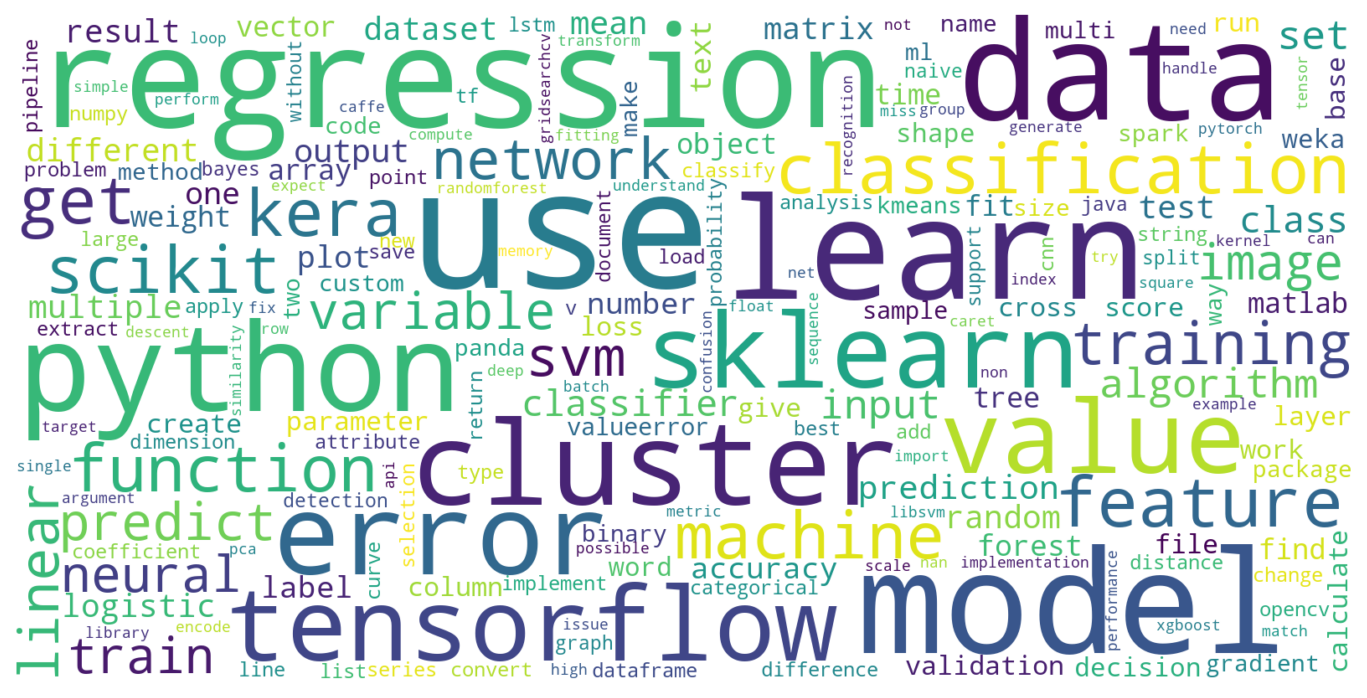

In [127]:
draw_wordcloud(titles_lem)

#### Bodies

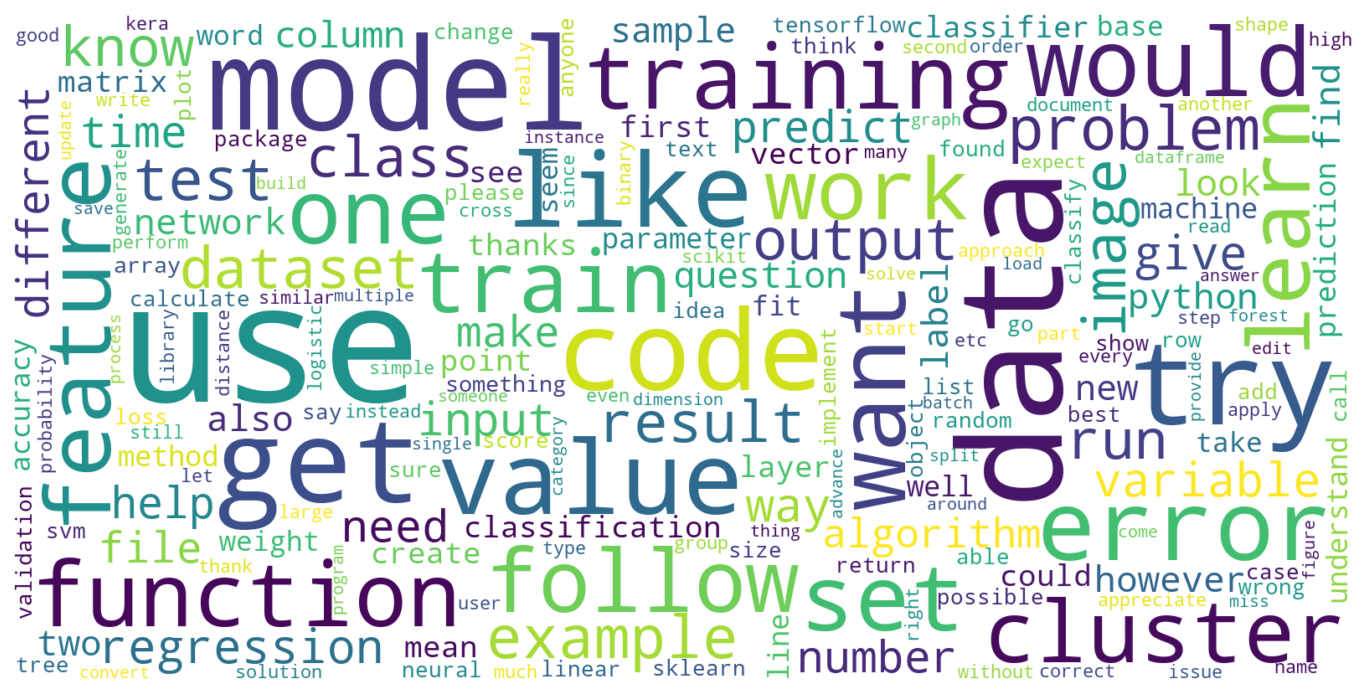

In [305]:
draw_wordcloud(bodies_lem)

#### Titles + bodies

In [542]:
questions_lem = [tl + bl for tl, bl in zip(titles_lem, bodies_lem)]

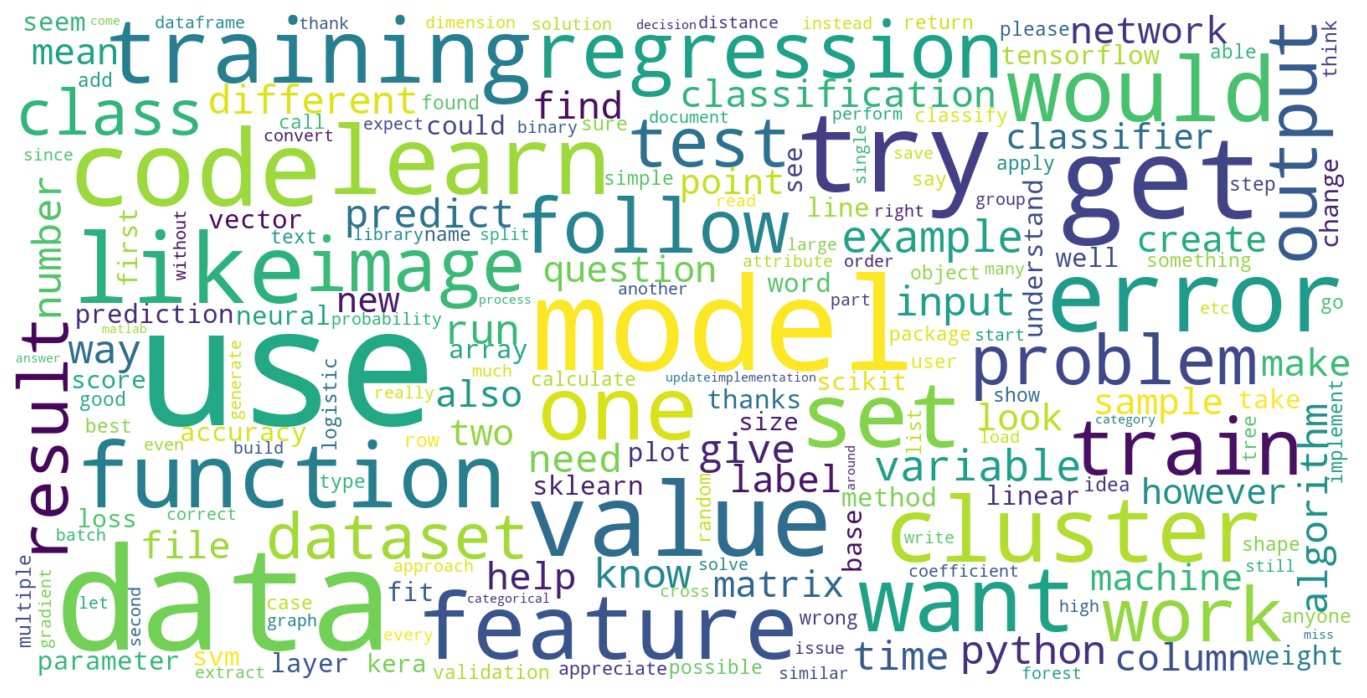

In [408]:
draw_wordcloud(questions_lem)

---
__We can see that titles have more contextual important words than bodies or questions(bodies+titles). So i think we need to weight bodies with less weight than titles or ingore them at all. It worth to take into account size of this entities, more size more time to response so titles are high priority.__

# Question to vector models

## Based on Word2Vec

In [44]:
from gensim.models import Word2Vec

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import NotFittedError

In [112]:
class Question2Vec:
    """
    Search for documents relevant to query.
    
    Parameters
    ----------
    wv_model : Word2Vec
        Base model.
    distance : str, default='cosine'
    - 'cosine'
        Use the cosine distance to measure question similarities.
    - 'wm' :: documents needed
        Use Word Movers' distance to measure question similarities.
    tf_idf : bool
        Use weights of Tfidf, only for 'cosine' distance.
    """
    
    def __init__(self, wv_model, distance='cosine', tf_idf=False):
        self.model = wv_model
        self.tfidf = tf_idf
        self.distance = distance
        self.embeddings_ = None
    
    def __repr__(self):
        return (f'Question2Vec(wv_mode={self.model}, distance={self.distance},' 
                + f' tf_idf={self.tfidf})')

    def q2vec(self, qwords):
        """Count vector of question.
        """
        feature_vec = np.zeros((self.model.vector_size, ), dtype='float32')
        n_words = 0
        for word in qwords:
            if word in self.model.wv.index2word:
                n_words += 1
                feature_vec += self.model[word]*self._weight(word)
        return feature_vec / n_words if n_words > 0 else feature_vec
    
    def rank_candidates(self, candidates):
        """Calculate ranks of candidate based on their similarity to main query.

        candidates : 2D array-like
            candidates[:, 0] -- main queries
            candidates[:, 1:r+1] -- ranked relevant questions
            candidates[:, r+1:] -- noise
        """
        ranks = []
        if self.distance == 'cosine':
            for cand in candidates:
                self.fit(cand[1:])
                ranks.append(self.predict_similar(cand[0], len(cand)-1))
        else:
            for cand in candidates:
                ranks.append(self.predict_similar(
                    cand[0], len(cand)-1, documents=cand[1:]))
        return ranks
    
    def fit(self, X, y=None):
        """Calculate embeddings of questions if 'cosine' else nothing.
        """
        if self.distance not in ['wm', 'cosine']:
            raise ValueError('No such distance type')
        if self.distance == 'wm':
            return self
        if self.tfidf:
            tfidf = TfidfVectorizer(analyzer=lambda x: x, ngram_range=(1, 3))
            tfidf.fit(X)
            max_idf = max(tfidf.idf_)
            self.word2weight_ = defaultdict(
                lambda: max_idf,  # If word not in vocab
                [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        self.embeddings_ = [self.q2vec(doc) for doc in X]
        return self
    
    def predict_similar(self, question, k, documents=None, rtrn_idx=True):
        """Return top k the most similar to question documents.
        
        question : list[str]
            prepared query as list of words
        documents : list, default=None
            List of candidates needed for 'wm' distance,
            each candidate have the same format as question.
        k : int
            number of the output similar questions
        rtrn_idx : bool, default=True
            Determine the output type should be indexes of docs or docs itself.
        """
        if self.distance == 'cosine' and self.embeddings_:
            sims = self.cosine_similarities(question)
            topk_idx = sims.argsort()[::-1][:k]
        elif self.distance == 'wm':
            sims = self.wm_distance(question, documents)
            topk_idx = sims.argsort()[:k]
        else:
            raise NotFittedError('This Qestion2Vec instance is not fitted yet.')
        return topk_idx if rtrn_idx else [documents[i] for i in topk_idx]

    def cosine_similarities(self, question):
        """Calculate cosine similarity between question and each document in embeddings_.
 
        question: list[str]
            question as list of words
        """
        if self.embeddings_ is None:
            raise NotFittedError('This Qestion2Vec instance is not fitted yet.')
        qvec = self.q2vec(question)[np.newaxis, :]
        similarities = cosine_similarity(qvec, self.embeddings_)
        return similarities[0]
    
    def make_similarity_matrix(self):
        """Build similarity matrix."""
        return cosine_similarity(self.embeddings_, self.embeddings_)
    
    def softcossim(self, v1, v2, sm):
        """Calculate soft-cosine similarity.
        """
        num = self.weight_product(v1, v2, sm)
        denom = (self.weight_product(v1,v1,sm))**0.5 * (self.weight_product(v2,v2,sm))**0.5
        return num / denom
    
    def weight_product(self, v1, v2, weights):
        """Calculate weighted element-wise vector product."""
        product = 0
        for i, v1i in enumerate(v1):
            for j, v2i in enumerate(v2):
                product += v1i*v2i*weights[i][j]
        return product
    
    def wm_distance(self, question, documents):
        return np.array([self.model.wv.wmdistance(question, sent) for sent in documents])
    
    def _weight(self, word):
        return self.word2weight_[word] if self.tfidf else 1

## InferSent (facebook)

[InferSent](https://github.com/facebookresearch/InferSent) is a sentence embeddings method that provides semantic representations for English sentences. It is trained on natural language inference data and generalizes well to many different tasks.

In [8]:
# %%bash

# mkdir encoder
# curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
# curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
# git clone https://github.com/facebookresearch/InferSent.git

Cloning into 'InferSent'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 259 (delta 7), reused 13 (delta 4), pack-reused 240
Receiving objects: 100% (259/259), 448.95 KiB | 783.00 KiB/s, done.
Resolving deltas: 100% (131/131), done.


In [19]:
# %%bash

# mkdir fastText
# curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
# unzip fastText/crawl-300d-2M.vec.zip -d fastText/


Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


In [4]:
import nltk
import torch
from InferSent.models import InferSent

In [96]:
class InferSentWrapper:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None):
        """Calculate embeddings.
        """
        self.embeddings_ = self.model.encode(X, bsize=128)
        return self
    
    def rank_candidates(self, candidates):
        ranks = []
        offset = 0
        for i, cand in enumerate(candidates):
            svec = self.embeddings_[offset]
            dists = []
            for j in range(1, len(cand)):
                dists.append(cosine_similarity(
                    [svec], [self.embeddings_[j + offset]])[0][0])
            ranks.append(np.array(dists).argsort()[::-1])
            offset += len(cand)
        return ranks
    
    def build_vocab(self, X):
        self.model.build_vocab(X)
        
    def top_similar(self, q, k=None):
        svec = self.model.encode([q])[0]
        dists = cosine_similarity([svec], self.embeddings_)[0]
        top = np.array(dists).argsort()[::-1][:k]
        return top

# Test dataset

__I made a small test dataset, (question + 5 similar questions in descending order of their relevance to main question) for 50 queries.__

Load the test dataset

In [544]:
with open('data/test/similar_docs.json', 'r') as f:
    candidates = json.load(f)

In [545]:
len(candidates)

50

In [546]:
candidates[0]

['calculate confusion matrix',
 'How do I calculate the Confusion Matrix? ',
 'How to calculate confusion matrix for a training model ?',
 'Faster method of computing confusion matrix? ',
 'Python: calculate confusion matrix after crossvalidation ',
 'calculate precision and recall in a confusion matrix ']

Process test dataset

In [550]:
prepare_pipe = Pipeline([
    ('clean', TextCleaner(retr_type='list')),
    ('normalize', TextNormalizer(retr_type='list'))
])

In [551]:
prepare_pipe.set_params(normalize__method='lemma')
prepared_cands_lem = prepare_pipe.fit_transform(candidates)

prepare_pipe.set_params(normalize__method='stem')
prepared_cands_stem = prepare_pipe.fit_transform(candidates)

In [556]:
prepared_cands_lem[1]

[['model', 'prediction', 'update', 'tensorflow'],
 ['tensorflow', 'return', 'prediction'],
 ['predict', 'tensorflow', 'model', 'work'],
 ['use', 'tensorflow', 'layer', 'model', 'train'],
 ['tensorflow', 'multi', 'class', 'training', 'prediction'],
 ['tensorflow',
  'object',
  'detection',
  'train',
  'py',
  'fails',
  'run',
  'cloud',
  'machine',
  'learn',
  'engine']]

Save

In [650]:
# with open('data/test/lem_docs.json', 'w') as f:
#     json.dump(prepared_cands_lem, f)
# with open('data/test/stem_docs.json', 'w') as f:
#     json.dump(prepared_cands_stem, f)

# Models estimating

How to estimate models that evaluate text similarities?

Let's take the ranked relevant to main query questions and add some noisy questions. Then __count__ how often and how many relevant questions our model pick from the top _K_ ranked by the model noised questions.

However, this approach ignores rank(or relevance) itself. Hence we should also consider the __places__ of the relevant questions in the sorted by rank list of candidates.

## Metrics

HitsCount and [nDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG) scores are suitable metrics for this task.

### Hits count for one query
The number of correct hits for one query and some _K_:

$$ \text{Hits1@K}(q) = \frac{1}{min(r,K)}\sum_{i=1}^K \, [qs_i \in rqs)]$$


$q$ - the main query,

$qs_i$ - i-th question(candidate), $rqs$ - relevant to main query(q) questions, 

$r = len(rqs)$,

$[expression]$ is Iverson bracket.

### The Total Hits count

$$\text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, Hits1@K(q_i)$$

where $N$ is the number of queries.


### DCG - Discounted Cumulative Gain

$${\displaystyle \mathrm {DCG_{p}} =\sum _{i=1}^{p}{\frac {rank_{i}}{\log _{2}(i+1)}}}$$

p means rank position estimated by a model

### nDCG - Normalized DCG

$${\mathrm {nDCG_{{p}}}}={\frac {DCG_{{p}}}{IDCG_{{p}}}}$$

where IDCG is ideal discounted cumulative gain,

$${\displaystyle \mathrm {IDCG_{p}} =\sum _{i=1}^{|RANK_{p}|}{\frac {2^{rank_{i}}-1}{\log _{2}(i+1)}}}$$

$|RANK_{p}| = r$

In [20]:
def hits_count(ranks, k, cands_num):
    """Calculate Hits count.
    
    k : int
        number of the top candidates to search
    cands_num : int
        number of relevant questions
    """
    total_hits = 0
    n = min(cands_num, k)
    for rank in ranks:
        total_hits += sum(1 for r in rank[:k] if r < cands_num) / n
    return total_hits / len(ranks)

def ndcg_score(ranks, k, cands_num):
    """Calculate normalized discounted cumulative gain.
    
    k : int
        number of the top candidates to search
    cands_num : int
        number of relevant questions
    """
    dcg = 0
    n = min(cands_num, k)
    idcg_i = sum((n-i) / np.log2(i+2) for i in range(n))
    for rank in ranks:
        dcg_i = 0
        for i in range(n):
            dcg_i += (n-rank[i]) / np.log2(i+2) if rank[i] < n else 0
        dcg += dcg_i / idcg_i
    return dcg / len(ranks)

def print_result(ranks, cands_num):
    """Print nDCG and Hits scores based on ranks.
    """
    end = '\t'
    dcg_total = hit_total = 0
    for i in [1, 2, 3, 4, 5, 10, 50, 100, 250, 500]:
        hit = hits_count(ranks, i, cands_num)
        print(f'Hits@{i}: {hit:.2f}', end=end)
        if i <= cands_num:
            hit_total += hit
            dcg = ndcg_score(ranks, i, cands_num)
            dcg_total += dcg
            print(f'nDCG@{i}: {dcg:.2f}')
            if i == cands_num:
                end = '\n'
    print(f"Hits_AVG@{cands_num}: {hit_total/cands_num:.3f}\t"
            f"nDCG_AVG@{cands_num}: {dcg_total/cands_num:.3f}")

## Word2vec

In [8]:
from sklearn.model_selection import ParameterGrid
from sklearn.utils import check_random_state

Load the processed titles and test dataset

In [7]:
with open('data/documents/title_stem.json', 'r') as ts, \
     open('data/documents/title_lemma.json', 'r') as tl:
    titles_stem = json.load(ts)
    titles_lem = json.load(tl)
    
with open('data/test/lem_docs.json', 'r') as ld, \
     open('data/test/stem_docs.json', 'r') as sd:
    ranked_cands_le = json.load(ld)
    ranked_cands_st = json.load(sd)

### Add noise to ranked questions

In [9]:
def add_noise_candidates(candidates_batch, noise_docs, num_noise=100, random_state=None):
    noised_batch = []
    random_state_ = check_random_state(random_state)
    for cands in candidates_batch:
        noised_cands = cands.copy()
        rsample = random_state_.randint(len(noise_docs), size=num_noise)
        for k in rsample:
            noised_cands.append(noise_docs[k])
        noised_batch.append(noised_cands)
    return noised_batch

500 random questions for each batch of relevant questions.

In [128]:
r = len(ranked_cands_le[0]) - 1  # len(rqs)
noised_candidates_le = add_noise_candidates(ranked_cands_le, titles_lem, 500, 42)
noised_candidates_st = add_noise_candidates(ranked_cands_st, titles_stem, 500, 42)

In [129]:
def models_profiling(docs, params, r):
    """Question2Vec model profiling over specified parameters and documents.
    """
    for method in docs:
        print(f'DOCS_NORMALIZTION_TYPE: {method}\n')
        X_train, X_test = docs[method]
        w2vec_model = Word2Vec(
            X_train, min_count=9, 
            size=min(len(X_test[0]), 150),
            window=5, workers=4, hs=1, sg=1
        )
        grid = ParameterGrid(params)
        for arg in grid:
            print('params:', arg)
            print('--'*30)
            # Configure Question2Vec model
            q2vec_model = Question2Vec(
                w2vec_model, distance=arg['distance'], tf_idf=arg['tf_idf'])
            print('Ranking...')
            start = time.time()
            q2vec_ranks = q2vec_model.rank_candidates(X_test)
            print(f'Rank time: {(time.time()-start):.3f}s')
            print('.'*12 + 'results' + '.'*12)
            print_result(q2vec_ranks, r)
            print()
    

In [121]:
docs = {'lemmatization': (titles_lem, noised_candidates_le), 'stemming': (titles_stem, noised_candidates_st), }
params = {'distance': ['cosine', 'wm'], 'tf_idf': [False, True]}

In [122]:
models_profiling(docs, params, r)

DOCS_NORMALIZTION_TYPE: lemmatization

params: {'distance': 'cosine', 'tf_idf': False}
------------------------------------------------------------
Ranking...
Rank time: 3.492s
............results............
Hits@1: 0.96	nDCG@1: 0.40
Hits@2: 0.92	nDCG@2: 0.62
Hits@3: 0.86	nDCG@3: 0.70
Hits@4: 0.79	nDCG@4: 0.75
Hits@5: 0.71	nDCG@5: 0.78
Hits@10: 0.84
Hits@50: 0.96
Hits@100: 0.98
Hits@250: 1.00
Hits@500: 1.00
Hits_AVG@5: 0.847	nDCG_AVG@5: 0.652

params: {'distance': 'cosine', 'tf_idf': True}
------------------------------------------------------------
Ranking...
Rank time: 15.018s
............results............
Hits@1: 0.90	nDCG@1: 0.44
Hits@2: 0.87	nDCG@2: 0.60
Hits@3: 0.83	nDCG@3: 0.67
Hits@4: 0.75	nDCG@4: 0.72
Hits@5: 0.68	nDCG@5: 0.75
Hits@10: 0.84
Hits@50: 0.97
Hits@100: 0.98
Hits@250: 1.00
Hits@500: 1.00
Hits_AVG@5: 0.805	nDCG_AVG@5: 0.636

params: {'distance': 'wm', 'tf_idf': False}
------------------------------------------------------------
Ranking...
Rank time: 14.828s
......

## InferSent

Create model

In [6]:
V = 2
MODEL_PATH = f'encoder/infersent{V}.pkl'
W2V_PATH = 'GloVe/glove.840B.300d.txt' if V == 1 else 'fastText/crawl-300d-2M.vec'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}

In [ ]:
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
infersent.set_w2v_path(W2V_PATH)

Load embeddings of K most frequent words

In [7]:
infersent.build_vocab_k_words(K=100000)

Vocab size : 100000


In [35]:
infersent_wrapper = InferSentWrapper(infersent)

In [36]:
infersent_wrapper.build_vocab(df.title)

Found 11546(/16248) words with w2v vectors
Vocab size : 11546


In [ ]:
infersent_wrapper.fit(df.title)

Test this model

In [392]:
sent = 'Best learning algorithm to make a decision tree in java?'

In [394]:
top_idx = infersent_wrapper.top_similar(sent, 5)

In [395]:
for i in top_idx:
    print(df.title[i])

best learning algorithm make decision tree java
type decision tree algorithm sklearn
java decision tree numeric attributes classes
help coding decision tree python
prepare data decision tree algorithm


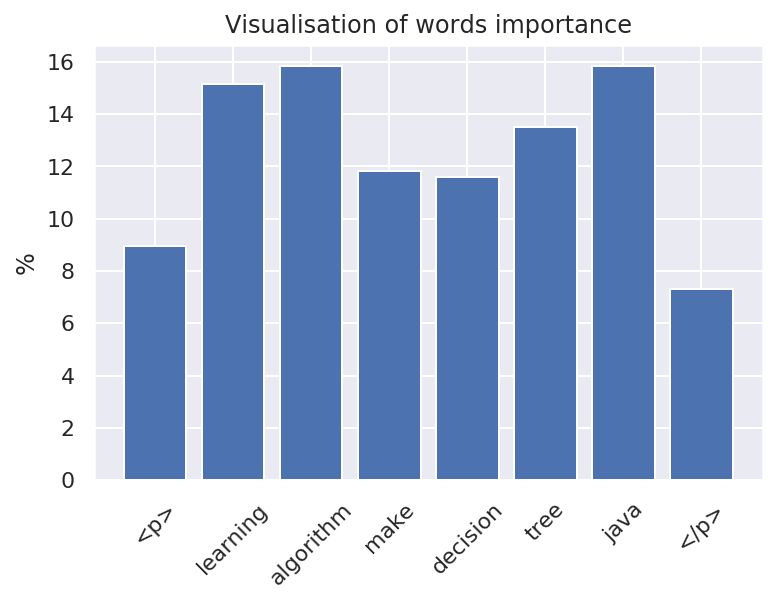

(tensor([[ 0.0075, -0.1045,  0.1044,  ..., -0.0270,  0.0059,  0.0157]],
        grad_fn=<MaxBackward0>), array([[0, 4, 6, ..., 3, 6, 4]]))

In [398]:
infersent.visualize(sent, tokenize=True)

Add noise

In [16]:
noised_sents = add_noise_candidates(ranked_cands_le, df.title, 500, 42)

In [17]:
flat_sents = []
for sents in noised_sents:
    flat_sents.extend(sents)

In [39]:
ranks_infersent = infersent_wrapper.rank_candidates(noised_sents)

In [41]:
print_result(ranks_infersent, r)

HIT@1: 0.71	DCG@1: 0.40
HIT@2: 0.68	DCG@2: 0.53
HIT@3: 0.64	DCG@3: 0.57
HIT@4: 0.58	DCG@4: 0.60
HIT@10: 0.69
HIT@50: 0.86
HIT@100: 0.91
HIT@250: 0.98
HIT@500: 1.00

HIT_AVG@4: 0.651	DCG_AVG@4: 0.524


---

## Conclusion

The are many approaches to measuring similarity between questions. Several of them have been discussed in this notebook:
* Approaches based on Word2Vec
    * Question representation: TfIdf-weighted or not average of word embeddings;
    * Vectors similarity: cosine similarity and word movers' distance.
* Ready solution - [InferSent](https://github.com/facebookresearch/InferSent).

And metrics to estimate these models:
   * [nDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG) - normalized discounted cumulative gain;
   * Hits count.
   
Some obseravtions:
* About data:
    * Python becomes more popular while matlab lose its in the machine learning field.
    * Tag with the largest popularity(density) increase is _Keras_ that have 43x density growth in 2016.
    * The most common words in question titles are _cluster, python, regression, data, tensorflow, sklearn, model_. 
    
* About text preparing:
    * Lemmatization proven itself better than stemming.
     
* About models:
    * InferSent is good enough, but was trained on common words and not suitable for the machine-learning words.

The best model in terms of quality / timeToReponse is __the model based on skip-gram Wor2Vec that trained on lemmatized question titles with the cosine metric to measure similarity between questions__.